In [1]:
import os
import pickle

import community.community_louvain as community_louvain
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from shapely.geometry import Point

from constants import (
    AGGR_GRAPH_PATH,
    COMMUNITY_PARTITIONS_FPATH,
    DISTANCE_NEGATIVE_THRESHOLD,
    DISTANCE_POSITIVE_THRESHOLD,
    FINAL_GRAPH_PATH,
)

In [2]:
G = nx.read_graphml(AGGR_GRAPH_PATH)
print("Graph loaded successfully.")
UG = nx.Graph(G)
print("Nodes:", UG.number_of_nodes())
print("Edges:", UG.number_of_edges())

Graph loaded successfully.
Nodes: 145652
Edges: 199277


In [3]:
pos = {}
for n, data in UG.nodes(data=True):
    try:
        x = float(data.get("x"))
        y = float(data.get("y"))
        pos[n] = (x, y)
    except (TypeError, ValueError):
        pos[n] = None

pos = {n: p for n, p in pos.items() if p is not None}

print("Nodes with coordinates:", len(pos))

# Connected components
cc = list(nx.connected_components(UG))
print("Connected components:", len(cc))
largest_cc = max(cc, key=len)
smallest_cc = min(cc, key=len)
print("Largest CC size:", len(largest_cc))
print("Smallest CC size:", len(smallest_cc))

Nodes with coordinates: 145652
Connected components: 3
Largest CC size: 145131
Smallest CC size: 226


## Louvain + One-Hot Encoding Community Labels

In [ ]:
"""
NOTE: Louvain is a probabilistic algorithm for identifying communities within a graph.
The problem is that in our case, we as humans generally associate a community w/ a residential society
e.g Faisal Town or DHA.

This isn't a huge problem, but in the long term, we should probably demarcate a 'community' by hand.
"""

if not os.path.exists(COMMUNITY_PARTITIONS_FPATH):
    print("Computing communities.")
    partition = community_louvain.best_partition(UG, resolution=0.6)

    with open(COMMUNITY_PARTITIONS_FPATH, "wb") as f:
        pickle.dump(partition, f)
else:
    print("Community partitions found. Loading.")
    with open(COMMUNITY_PARTITIONS_FPATH, "rb") as f:
        partition = pickle.load(f)

Computing communities.


In [5]:
comm_ids = sorted(set(partition.values()))
col_names = {cid: f"comm_{i}" for i, cid in enumerate(comm_ids)}

attrs = {}
for n in UG.nodes():
    node_comm = partition.get(n)
    # create one-hot dict with all zeros then set the community column to 1
    d = {name: 0 for name in col_names.values()}
    if node_comm is not None:
        d[col_names[node_comm]] = 1
    attrs[n] = d

nx.set_node_attributes(UG, attrs)

num_comms = len(set(partition.values()))
print(f"Detected communities: {num_comms}")

Detected communities: 160


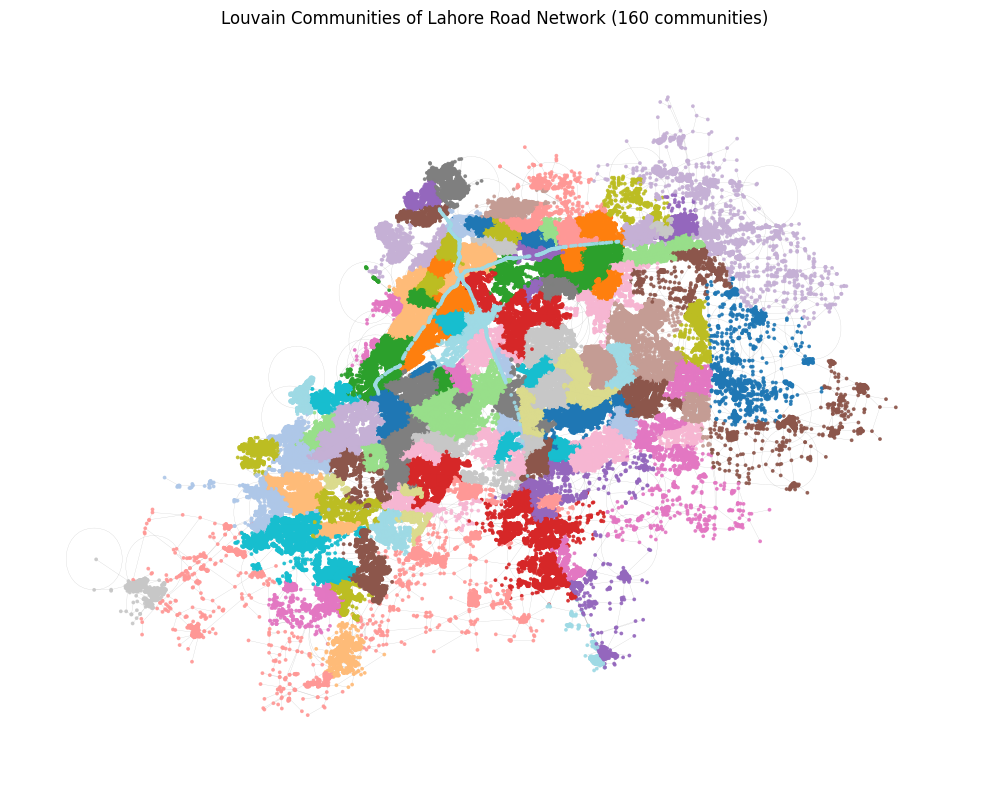

In [6]:
unique_coms = sorted(set(partition.values()))
color_map = {c: i for i, c in enumerate(unique_coms)}
node_colors = [color_map[partition[n]] for n in UG.nodes()]

plt.figure(figsize=(10, 8))
plt.title(
    f"Louvain Communities of Lahore Road Network ({num_comms} communities)", fontsize=12
)

nx.draw_networkx_nodes(
    UG,
    pos=pos,
    node_size=3,
    node_color=node_colors,
    cmap=plt.cm.tab20,  # type: ignore
    alpha=0.85,
)

nx.draw_networkx_edges(UG, pos=pos, width=0.2, edge_color="gray", alpha=0.4)

plt.axis("off")
plt.tight_layout()
plt.show()

#### Generate Labels

In [7]:
nodes_df = pd.DataFrame.from_dict(dict(UG.nodes(data=True)), orient="index")

In [ ]:
nodes_df["distance_to_nearest_stop"] = nodes_df["distance_to_nearest_stop"].astype(
    float
)

nodes_df["population"] = nodes_df["population"].astype(float)

median_pop = nodes_df["population"].median()


def label_fn(row):
    d = row["distance_to_nearest_stop"]
    p = row["population"]

    if d < DISTANCE_POSITIVE_THRESHOLD and p > median_pop:
        return 1  # well-served + high population
    if d > DISTANCE_NEGATIVE_THRESHOLD and p < median_pop:
        return 0  # underserved + low population
    return np.nan  # ambiguous → test set


nodes_df["label"] = nodes_df.apply(label_fn, axis=1)

nx.set_node_attributes(UG, nodes_df["label"].to_dict(), name="label")

In [14]:
if not os.path.exists(FINAL_GRAPH_PATH):
    print("Saving final graph.")
    with open(FINAL_GRAPH_PATH, "wb") as f:
        pickle.dump(UG, f)

#### Test Set Plotting

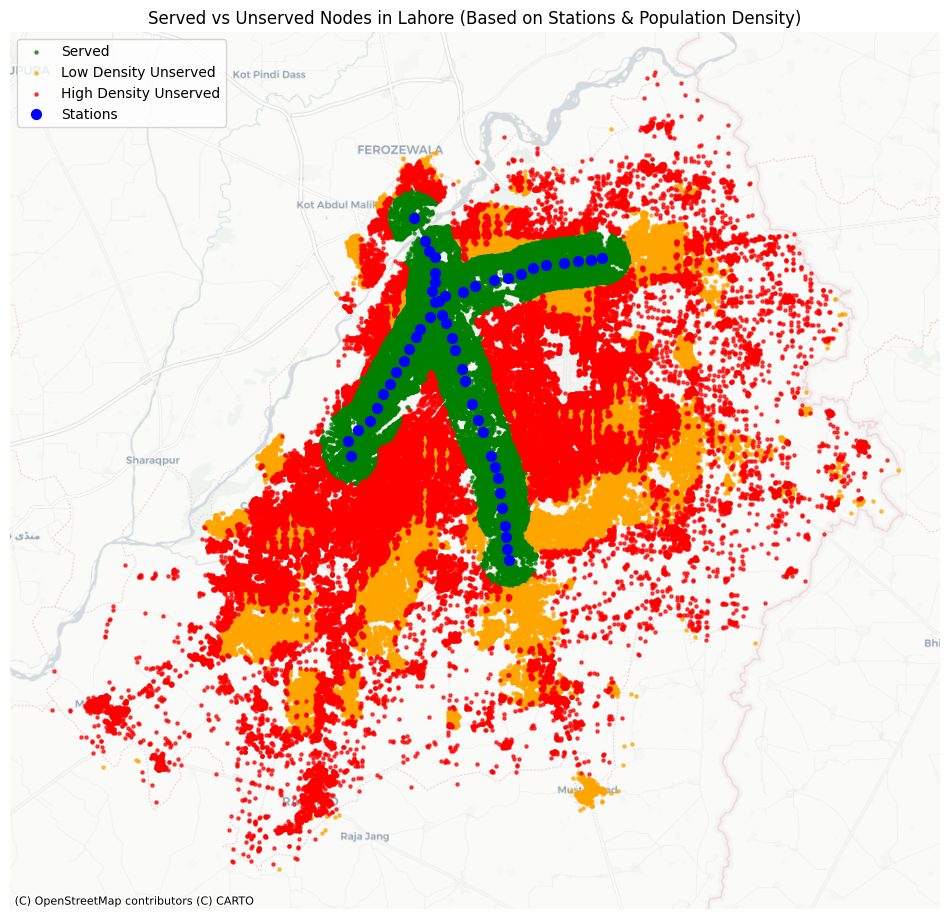

In [ ]:
def get_attr(
    node, key, default=0.0
):  # Numeric Conversion as values are saved in string format
    return float(G.nodes[node].get(key, default))


# ------------------------------
# Define thresholds
# ------------------------------
DIST_THRESHOLD = 2000  # meters
pop_values = [get_attr(n, "population") for n in G.nodes()]
POP_MEDIAN = np.median(pop_values)

# ------------------------------
# Classify nodes
# ------------------------------
node_records = []
for n in G.nodes():
    x, y = get_attr(n, "x"), get_attr(n, "y")
    if x is None or y is None:
        continue

    dist = get_attr(n, "distance_to_nearest_stop")
    pop = get_attr(n, "population")

    if dist <= DIST_THRESHOLD:
        status = "served"
    elif dist > DIST_THRESHOLD and pop <= POP_MEDIAN:
        status = "low_density_unserved"
    else:
        status = "high_density_unserved"

    node_records.append(
        {
            "geometry": Point(x, y),
            "population": pop,
            "distance_to_station": dist,
            "served_status": status,
        }
    )

# ------------------------------
# Create GeoDataFrame
# ------------------------------
utm_crs = "EPSG:32643"  # UTM zone 43N for Lahore
gdf_nodes = gpd.GeoDataFrame(node_records, crs=utm_crs)

# ------------------------------
# Load stations
# ------------------------------
gdf_stations = gpd.read_file("../data/citylines/lahore_stations.geojson")
gdf_stations = gdf_stations.to_crs(utm_crs)

# ------------------------------
# Reproject to Web Mercator for basemap
# ------------------------------
gdf_nodes = gdf_nodes.to_crs(epsg=3857)
gdf_stations = gdf_stations.to_crs(epsg=3857)

# ------------------------------
# Plot nodes
# ------------------------------
fig, ax = plt.subplots(figsize=(12, 12))

colors = {
    "served": "green",
    "low_density_unserved": "orange",
    "high_density_unserved": "red",
}

for status, color in colors.items():
    gdf_nodes[gdf_nodes["served_status"] == status].plot(
        ax=ax,
        color=color,
        markersize=5,
        alpha=0.7,
        label=status.replace("_", " ").title(),
    )

gdf_stations.plot(ax=ax, color="blue", markersize=50, marker="o", label="Stations")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # type: ignore

ax.set_title(
    "Served vs Unserved Nodes in Lahore (Based on Stations & Population Density)"
)
ax.set_axis_off()
plt.legend()
plt.show()